In [1]:
# Tại bên này có nhiều version, bỏ qua
import sys
print(sys.executable)
assert str(sys.executable) == 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python38\\python.exe'

C:\Users\user\AppData\Local\Programs\Python\Python38\python.exe


In [211]:
from pandas_datareader import data as pdr
import datetime
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from requests_html import HTML
import time

%matplotlib inline
import matplotlib.pyplot as plt
import os.path
import numpy as np
import math


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [265]:
dt = pd.to_datetime('17/12/2020', format='%d/%m/%Y')
dt.strftime('%Y-%m-%d')

'2020-12-17'

# Get data with Crawler

In [266]:
row_id = []
for i in range(1, 21):
    if i%2: row_id.append(str(i).zfill(2) + '_')
    else: row_id.append(str(i).zfill(2) + '_alt')

def get_stock_data(stock_symbol, output_file):
    url = 'https://s.cafef.vn/Lich-su-giao-dich-' + stock_symbol + '-1.chn'    
    
    file = open(output_file, 'w', encoding='utf-8')
    file.write(f'Date,Open,High,Low,Close\n')

    driver = webdriver.Chrome(executable_path='./chromedriver.exe')
    driver.get(url)
    html = HTML(html=driver.page_source)

    while True:        
        for i in row_id:
            html = HTML(html=driver.page_source)
            row = html.find('tr#ctl00_ContentPlaceHolder1_ctl03_rptData2_ctl' + i + 'itemTR', first=True)
            if row:                
                date = row.find('td.Item_DateItem', first=True).text
                date = pd.to_datetime(date, format='%d/%m/%Y').strftime('%Y-%m-%d')
                
                prices = row.find('td.Item_Price10')
                op, hi, lo, cl = prices[5].text, prices[6].text, prices[7].text, prices[1].text
                file.write(f'{date},{op},{hi},{lo},{cl}\n')

        button = driver.find_elements(By.LINK_TEXT, '>')
        if len(button) > 0:
            button[0].click()
            time.sleep(1)
        else:
            break

    file.close()

In [267]:
stock = ['BVH', 'SSI', 'HDG']

In [268]:
for symbol in stock:
    get_stock_data(symbol, symbol+'.csv')

## Visualize

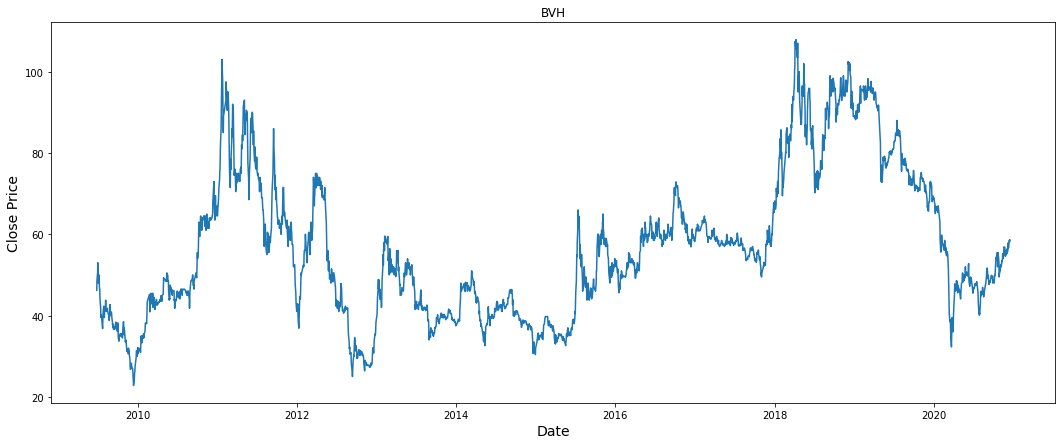

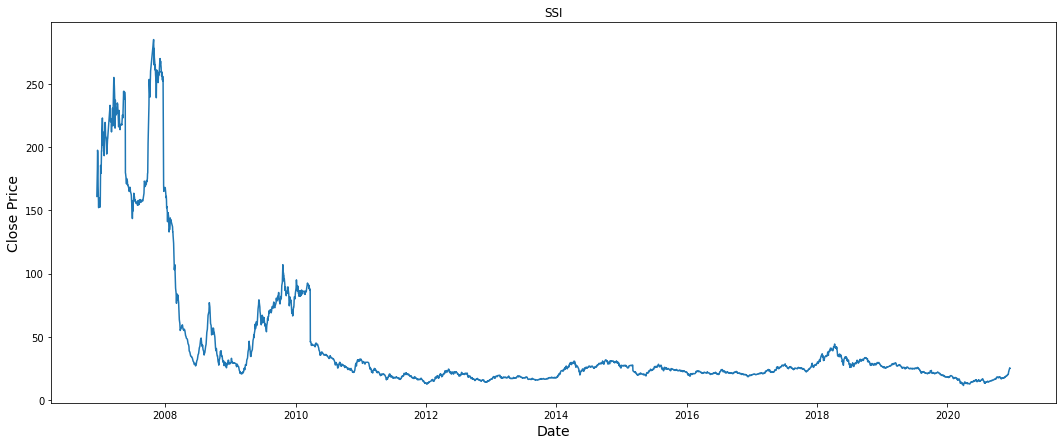

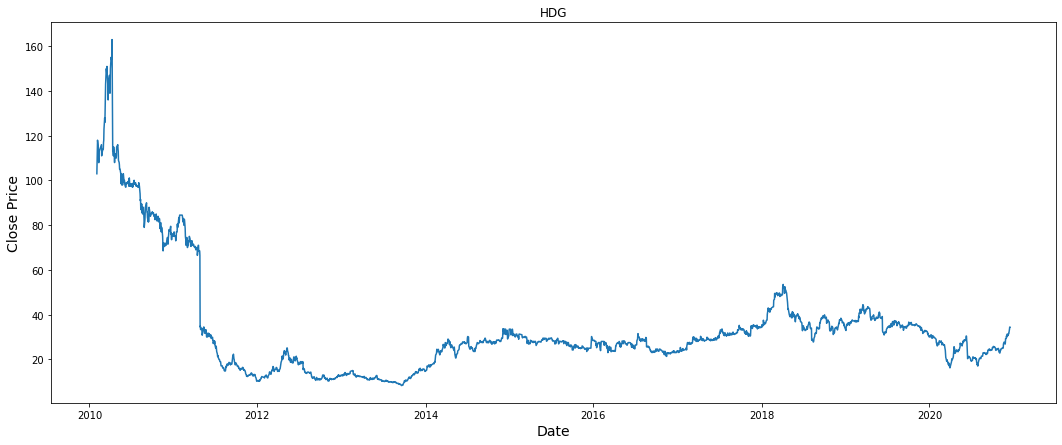

In [272]:
for symbol in stock:
    df = pd.read_csv(symbol+'.csv', parse_dates={'Datetime':['Date']}).iloc[::-1]
    df.set_index(['Datetime'], inplace = True) 
    plt.figure(figsize = (18,7))
    plt.plot(df['Close'])
    plt.title(symbol)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Close Price',fontsize=14)

    plt.show()

# Forecasting

In [271]:
BVH = pd.read_csv('BVH.csv', parse_dates={'Datetime':['Date']}).iloc[::-1]
BVH.set_index(['Datetime'], inplace = True)
BVH

,Open,High,Low,Close
Datetime,,,,
2009-06-25,46.2,46.2,45.0,46.2
2009-06-26,48.5,48.5,48.0,48.5
2009-06-29,50.5,50.5,50.5,50.5
2009-06-30,53.0,53.0,53.0,53.0
2009-07-01,50.5,51.5,50.5,50.5
...,...,...,...,...
2020-12-10,57.9,58.0,56.5,56.7
2020-12-11,56.7,57.5,56.0,57.5
2020-12-14,58.0,59.4,57.3,58.6


## Scaling and split data

In [275]:
def scale_and_split_data(data, train_ratio, time_window):
    split_threshold = math.ceil(len(data)*train_ratio)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data.to_numpy().reshape(-1, 1))
    
    scaled_train = scaled_data[:split_threshold]
    scaled_test = scaled_data[split_threshold - time_window:] # Test cần lấy n ngày trước để tạo x_test cho valid[0]
    
    # x_train and y_train datasets
    x_train = []
    y_train = []

    for i in range(time_window, len(scaled_train)):
        x_train.append(scaled_train[i-time_window:i,0])
        y_train.append(scaled_train[i,0])
        #if i == time_window + 1:
            #print(x_train)
            #print(y_train)

    x_train = np.reshape(np.array(x_train), (len(x_train), time_window, 1))
    y_train = np.array(y_train)
    
    # x_test and y_test datasets
    x_test = []
    y_test =  scaled_data[split_threshold:]
    for i in range(time_window, len(scaled_test)):
        x_test.append(scaled_test[i-time_window:i,0])

    x_test = np.reshape(np.array(x_test), (len(x_test), time_window, 1))

    x_test.shape, y_test.shape
    
    # validation
    train_data = data[:split_threshold]
    valid_data = data[split_threshold:]
    
    return scaler, x_train, y_train, x_test, y_test, train_data, valid_data

In [382]:
ratio = 0.8
time_window = 100

scaler, x_train, y_train, x_test, y_test, train_data, valid_data = scale_and_split_data(BVH['Close'], ratio, time_window)

## Build LSTM model

In [361]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model

In [362]:
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
2195/2195 [==============================] - 69s 32ms/step - loss: 0.0025
Epoch 2/2
2195/2195 [==============================] - 69s 32ms/step - loss: 8.9318e-04


## Validation

In [363]:
predictions = model.predict(x_test) 

In [402]:
valid_vs_prediction = pd.DataFrame(valid_data)
valid_vs_prediction['Predicted'] = scaler.inverse_transform(predictions) #Từ scaled -> giá trị cũ
valid_vs_prediction

,Close,Predicted
Datetime,,
2018-09-06,86.0,85.312119
2018-09-07,88.4,82.779213
2018-09-10,89.5,84.485222
2018-09-11,95.7,86.690262
2018-09-12,95.0,92.829140
...,...,...
2020-12-10,56.7,57.552612
2020-12-11,57.5,56.913532
2020-12-14,58.6,56.945511


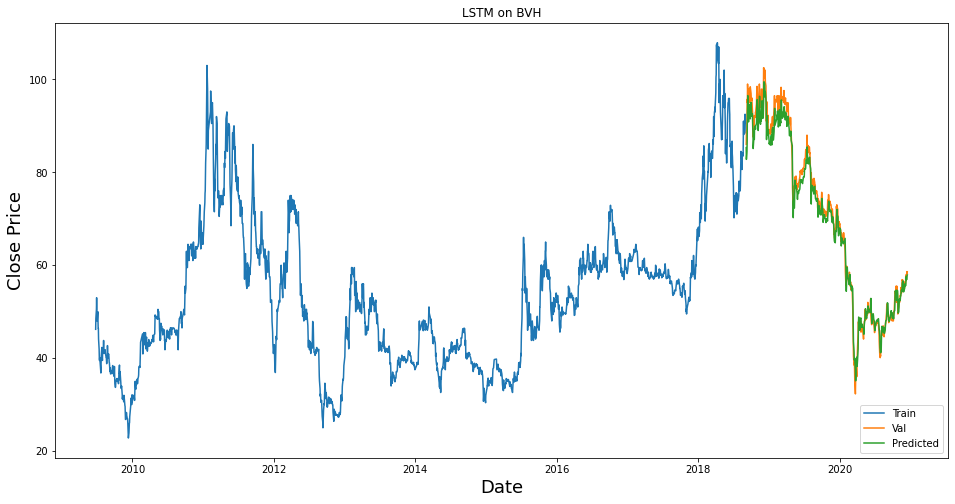

In [405]:
plt.figure(figsize=(16,8))
plt.title('LSTM on BVH')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train_data)
plt.plot(valid_vs_prediction[['Close', 'Predicted']])
plt.legend(['Train', 'Val', 'Predicted'], loc='lower right')
plt.show()

In [366]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

0.028198954186281475

## Prediction

In [414]:
def predict(model, scaler, data, time_window, num_of_date):
    x = scaler.transform(data[-time_window:].to_numpy().reshape(-1, 1))[:,0]

    prediction = []

    for i in range(num_of_date):
        y = model.predict(np.reshape(np.array(x), (1, time_window, 1)))
        #if i<3:
        #    print(x)
         #   print(y[0])
        x = np.delete(x, 0)
        x = np.append(x, y[0])
        prediction.append(y[0])
        
    unscaled_prediction = scaler.inverse_transform(prediction)
    
    idx = pd.date_range(data.index[-1], periods=num_of_date+1, freq='1d')[1:]
    return pd.Series(unscaled_prediction[:,0], index=idx)

In [415]:
next50 = predict(model, scaler, BVH['Close'], time_window, 50)

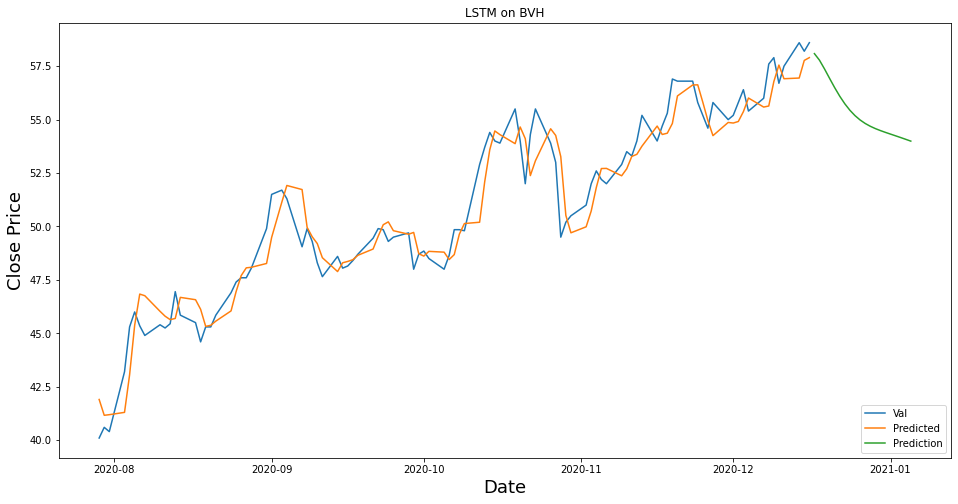

In [417]:
plt.figure(figsize=(16,8))
plt.title('LSTM on BVH')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(valid_vs_prediction[['Close', 'Predicted']][-100:])
plt.plot(next20)
plt.legend(['Val', 'Predicted', 'Prediction'], loc='lower right')
plt.show()

# Ref

https://insights.magestore.com/posts/giai-thuat-time-series-forecasting
https://www.datacamp.com/community/tutorials/lstm-python-stock-market
https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb
https://viblo.asia/p/lam-quen-voi-keras-gGJ59mxJ5X2